In [21]:
# http://techforcurious.website/how-to-save-data-from-oscilloscope-using-python-in-linux/#more-348
 
# import libraries
import os # for accessing files/directories
import pandas as pd # for data processing
import numpy as np # for data processing
import pyvisa

#connect to scope
oscope_ready = False
try :
    rm = pyvisa.ResourceManager()
    scope = rm.open_resource('TCPIP0::192.168.10.2::inst0::INSTR')
    print(scope.query('*idn?'))
    scope.timeout = 100000
    numFrames1 = 1
    frameSize = 50000900
    scope.write('horizontal:fastframe:count {}'.format(numFrames1)) #set number of frames
    scope.write('horizontal:fastframe:state 1') #turn on fast frame
    scope.write('DATa:STARt 1')
    scope.write('DATa:STOP 500000')
    scope.write('save:waveform:fileformat spreadsheetcsv') #set format before data start/stop
    #scope.write('saveon:numevents 10')
    #print(scope.query('saveon:numevents?'))
    scope.write('save:waveform:data:start 1') #ensure data range is good
    scope.write('save:waveform:data:stop {}'.format(frameSize)) #ensure data range is good
    oscope_ready = True
except :
    print("failed to connect to o-scope")    

# serial device setup
serial_device = '/dev/ttyUSB0'
baud_rate = 9600
from serial import Serial
serial = Serial(serial_device)
serial.flush()

failed to connect to o-scope


'# directory setup\ndirectory = input("Folder name : ") \nif os.path.isdir(directory):\n    os.chdir(directory)\n    print("Using existing directory:",os.getcwd())\nelse:\n    os.mkdir(directory)\n    os.chdir(directory)\n    print("Created new directory:", os.getcwd())'

In [22]:
# read MCU ADC function
def read_adc() :
    line = ""
    while line == "" :
        serial.write(b'j')
        line = serial.readline().decode('ascii')
    return int(line)
    
# ADC sweep function
import board
import busio
import adafruit_mcp4728
import adafruit_ads1x15.ads1115 as ADS
from adafruit_ads1x15.analog_in import AnalogIn
i2c = busio.I2C(board.SCL, board.SDA)
dac =  adafruit_mcp4728.MCP4728(i2c).channel_a
adc = AnalogIn(ADS.ADS1115(i2c,address=0x49),ADS.P0)
def adc_sweep(step=10,vmax=3.3,dots=False) :
    limit = int(vmax/3.3 * 4095)
    df = pd.DataFrame(index=["raw_in","v_in","raw_out","v_out"])
    for i in range(0,limit+1,step) :
        if dots : 
            print('.',end='')
        dac.raw_value = i
        raw_out = read_adc()
        v_out = raw_out/4095 * 3.3
        v_in = adc.voltage
        df[i] = [i,v_in,raw_out,v_out]
    return df.T

In [23]:
def save_aclk() :
    #CH1: Aclk
    scope.write('recall:setup "vandysetupAclk1.set"')
    scope.query('*opc?') # sync
    #acquire a set of frames and then stop acquiring
    scope.write('acquire:state 0')
    scope.write('acquire:stopafter SEQUENCE')
    scope.write('acquire:state 1')
    scope.query('*opc?')
    scope.write('data:framestart 1') #controls starting frame
    scope.write('data:framestop 1') #controls ending frame
    #scope.write('FILESYSTEM:CWD \"F:\\"')
    #scope.write('FILESystem:MKDir \"F:\Channel1\Trial{}"'.format(Trialnum))
    filenameCh1 = r'F:\Channel1\Trial{}.csv'.format(i)
    scope.write('save:waveform CH1,"{}"'.format(filenameCh1))
    scope.query('*opc?')

def save_mclk() :
    #CH2: Mclk
    scope.write('recall:setup "vandysetupMclk2.set"')
    scope.query('*opc?') # sync
    #acquire a set of frames and then stop acquiring
    scope.write('acquire:state 0')
    scope.write('acquire:stopafter SEQUENCE')
    scope.write('acquire:state 1')
    scope.query('*opc?')
    scope.write('data:framestart 1') #controls starting frame
    scope.write('data:framestop 1') #controls ending frame
    #scope.write('FILESYSTEM:CWD \"F:\\"')
    #scope.write('FILESystem:MKDir \"F:\Channel2\Trial{}"'.format(Trialnum))
    filenameCh2 = r'F:\Channel2\Trial{}.csv'.format(i)
    scope.write('save:waveform CH2,"{}"'.format(filenameCh2))
    scope.query('*opc?')

In [33]:
while True :
    Trialnum = int(input("Trial number: "))
    if Trialnum == -1 :
        print('exiting')
        break
    i = Trialnum
    
    #save all channels to csv for oscope       
    if oscope_ready :
        scope.write('FILESYSTEM:CWD \"F:\\"')             #Changed F to D for new Flashdrive
        save_aclk()
        save_mclk()
    
    file = 'Trial'+ str(i) + '.csv'

    # sweep adc and save csv
    adc_data = adc_sweep(step=100,dots=True)
    adc_data.to_csv('data/adc/'+file)

Trial number: 0
...................................Trial number: -1
exiting


<AxesSubplot:xlabel='v_in'>

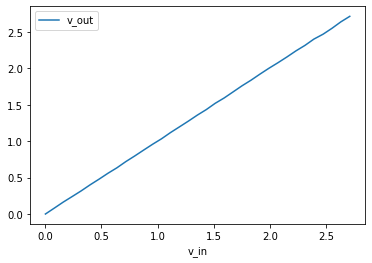

In [36]:
file = 'data/adc/Trial0.csv'
df = pd.read_csv(file,index_col=0)
df = df[['v_in','v_out']].set_index('v_in')
df.plot()